In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pylab as plt
%pylab inline
import numpy as np
import geopandas as gpd
import requests, zipfile, StringIO
import re
import multiprocessing as mp
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Read in additional files
url_zip = 'https://www.dropbox.com/sh/nlbj8whi5izbihr/AAD8CvKIYMnVpKUcBDazRe22a?dl=1'
r = requests.get(url_zip)
zip_ = zipfile.ZipFile(StringIO.StringIO(r.content))
filename_zip = 'ZIP_spatial/ZIP_CODE_040114.shp'
filename_tax = 'Tax_rates.csv'
filename_files = 'Files.csv'
filename_income = 'ACS_14_5YR_S1903_with_ann.csv'

In [3]:
# urls to the data
files = pd.read_csv(zip_.open(filename_files))
files.head(2)

,Filenames_Links
0,http://www1.nyc.gov/assets/finance/downloads/p...
1,http://www1.nyc.gov/assets/finance/downloads/p...


In [4]:
# Create three lists
list_sales_detail = list(files['Filenames_Links'][:5])
older_list = list(files['Filenames_Links'][5:20])
even_older_list = list(files['Filenames_Links'][20:])

In [5]:
# Read in zip code shapes for plotting
zipcodes = gpd.GeoDataFrame.from_file(filename_zip)#zip_.open(filename)) # Does not work...
zipcodes = zipcodes[['ZIPCODE','geometry']]
zipcodes.ZIPCODE = zipcodes.ZIPCODE.astype(int)
zipcodes.rename(columns={'ZIPCODE':'ZIP_CODE'},inplace=True)

In [6]:
# Add tax rate information
tax = pd.read_csv(zip_.open(filename_tax))
tax = tax.convert_objects(convert_numeric=True)
filename_assessment = 'dof_assessments_merged.csv'

In [7]:
# Reading newer data
# Create empty dataframe to store values
sales_detail_recent = pd.DataFrame()
for url in list_sales_detail:
    xl_data = pd.read_excel(url, header=4)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_recent = sales_detail_recent.append(xl_data)

In [8]:
# Reading older data
sales_detail_old = pd.DataFrame()
for url in older_list:
    xl_data = pd.read_excel(url, header=4)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_old = sales_detail_old.append(xl_data)

In [9]:
# Reading even older data
sales_detail_older = pd.DataFrame()
for url in even_older_list:
    xl_data = pd.read_excel(url, header=3)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_older = sales_detail_older.append(xl_data)

In [10]:
# Create a subset
def subset(df):
    df = df[(df.TAX_CLASS_AT_TIME_OF_SALE<3)&(df.SALE_PRICE>100000)&
        (df.BUILDING_CLASS_CATEGORY != '05  TAX CLASS 1 VACANT LAND')]
    return df

In [11]:
# Prepare datasets before joining
recent_data = subset(sales_detail_recent)
old_data = subset(sales_detail_old)
older_data = subset(sales_detail_older)

In [12]:
data = recent_data.append([old_data,older_data],ignore_index=True)

In [13]:
data.APARTMENT_NUMBER = data.APARTMENT_NUMBER.apply(lambda x: str(x).encode('ascii','ignore'))
data.APARTMENT_NUMBER = data.APARTMENT_NUMBER.apply(lambda x: x.strip().replace(' ','-'))

In [14]:
def nestCode(b, block, lot):
    return ''.join((b,  '0'*(5-len(block)),  block,  '0'*(4 - len(lot)),  lot))

#### Bins should be based on a per unit basis to account for apartment and building sales

In [15]:
# Approximate the value of each unit within the building sold
# If there are no residential units in the building, the sale_price_unit is just the sale_price
data['SALE_PRICE_UNIT'] = np.where(data['RESIDENTIAL_UNITS']==0,data.SALE_PRICE, 
                                   (data.SALE_PRICE/data.RESIDENTIAL_UNITS))

In [16]:
data['SALE_YEAR'] = data.SALE_DATE.map(lambda x: x.year)

# Round and convert to integer
data['SALE_PRICE_UNIT'] = np.around(data['SALE_PRICE_UNIT'],decimals=0)
data['SALE_PRICE_UNIT'] = data['SALE_PRICE_UNIT'].astype(int)

# Create BBL
data[['BOROUGH','BLOCK','LOT']] = data[['BOROUGH','BLOCK','LOT']].astype(str)
data['BBL'] = data.apply(lambda x: nestCode(x.BOROUGH, x.BLOCK, x.LOT), 1)

# Create bins
bins = [0,200000,400000,600000,800000,1000000,1500000,3000000,6000000,
        10000000,max(data.SALE_PRICE_UNIT)]
labels = np.arange(1,11,1)
data['PRICE_BINS'] = pd.cut(data.SALE_PRICE,bins,labels=labels)
data['PRICE_UNIT_BINS'] = pd.cut(data.SALE_PRICE_UNIT,bins,labels=labels)

# Ticks corresponding to bins
x_ticks = ['$(0-200k]','$(200k-400k]','$(400k-600k]','$(600k-800k]','$(800k-1m]',
           '$(1m-1.5m]','$(1.5m-3m]','$(3m-6m]','$(6m-10m]','$(10m-~170.5m]']

In [17]:
data.columns

Index([                       u'BOROUGH',                   u'NEIGHBORHOOD',
              u'BUILDING_CLASS_CATEGORY',           u'TAX_CLASS_AT_PRESENT',
                                u'BLOCK',                            u'LOT',
                            u'EASE-MENT',      u'BUILDING_CLASS_AT_PRESENT',
                              u'ADDRESS',               u'APARTMENT_NUMBER',
                             u'ZIP_CODE',              u'RESIDENTIAL_UNITS',
                     u'COMMERCIAL_UNITS',                    u'TOTAL_UNITS',
                     u'LAND_SQUARE_FEET',              u'GROSS_SQUARE_FEET',
                           u'YEAR_BUILT',      u'TAX_CLASS_AT_TIME_OF_SALE',
       u'BUILDING_CLASS_AT_TIME_OF_SALE',                     u'SALE_PRICE',
                            u'SALE_DATE',                u'SALE_PRICE_UNIT',
                            u'SALE_YEAR',                            u'BBL',
                           u'PRICE_BINS',                u'PRICE_UNIT_BINS']

In [18]:
# Select only relevant columns
data = data[['ZIP_CODE','SALE_DATE','SALE_YEAR','PRICE_BINS',
             'TAX_CLASS_AT_PRESENT','APARTMENT_NUMBER',
             'RESIDENTIAL_UNITS','TAX_CLASS_AT_TIME_OF_SALE',
             'SALE_PRICE','SALE_PRICE_UNIT','BBL','RESIDENTIAL_UNITS',
             'TOTAL_UNITS','LAND_SQUARE_FEET','PRICE_UNIT_BINS',
             'BUILDING_CLASS_AT_TIME_OF_SALE','YEAR_BUILT','BUILDING_CLASS_CATEGORY']]

In [19]:
tax # Output tax rates for visualization

,YEAR,CLASS 1,CLASS 2,CLASS 3,CLASS 4
0,2015,0.20,0.13,0.11,0.11
1,2014,0.19,0.13,0.11,0.11
2,2013,0.19,0.13,0.12,0.10
3,2012,0.19,0.13,0.12,0.10
4,2011,0.18,0.13,0.12,0.10
5,2010,0.17,0.13,0.13,0.10
6,2009,0.17,0.13,0.13,0.10
7,2008,0.16,0.13,0.12,0.10
8,2007,0.15,0.12,0.12,0.10


In [20]:
# Adding tax rates to datasets
def tax_rate(df,year):
    pos = tax[tax['YEAR'] == year].index.tolist()[0]
    df['TAX_RATE'] = np.where(df['TAX_CLASS_AT_TIME_OF_SALE']==1,
                              tax.iloc[pos,1],tax.iloc[pos,2])
    return df

In [21]:
headers = data.columns # Store headers

In [22]:
# Apply function to get tax rates
# Faster than an if statement within a loop
y2014 = data[data['SALE_YEAR']==2014]
y2013 = data[data['SALE_YEAR']==2013]
y2012 = data[data['SALE_YEAR']==2012]
y2011 = data[data['SALE_YEAR']==2011]
y2010 = data[data['SALE_YEAR']==2010]
y2009 = data[data['SALE_YEAR']==2009]
y2008 = data[data['SALE_YEAR']==2008]

y2008 = tax_rate(y2008,2008)
y2009 = tax_rate(y2009,2009)
y2010 = tax_rate(y2010,2010)
y2011 = tax_rate(y2011,2011)
y2012 = tax_rate(y2012,2012)
y2013 = tax_rate(y2013,2013)
y2014 = tax_rate(y2014,2014)

In [23]:
# Reunite data, use numpy because pandas is raising axis error
final = pd.DataFrame(np.concatenate([y2008,y2009,y2010,y2011,y2012,y2013,y2014]))
final.columns = headers.insert(len(headers), 'TAX_RATE')
final = final.convert_objects(convert_dates=True,convert_numeric=True)

In [24]:
# Get counts of the different bins, faster than conventional histogram
count = {}
for i in final['PRICE_BINS']:
    count[i] = count.get(i, 0) + 1   

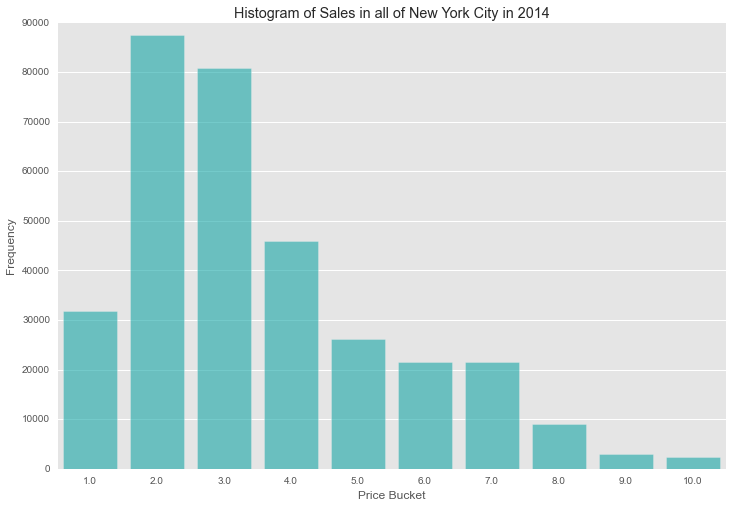

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame.from_dict(count, 'index')
sns.barplot(x=df.index,y=df[0],color='c',alpha=0.6)
plt.title('Histogram of Sales in all of New York City in 2014')
plt.ylabel('Frequency')
plt.xlabel('Price Bucket')
ax.xaxis.get_majorticklocs()
#ax.xaxis.set_ticks(x_ticks)
#plt.xticks([i for i in labels],[str(w) for w in x_ticks]) 
del df

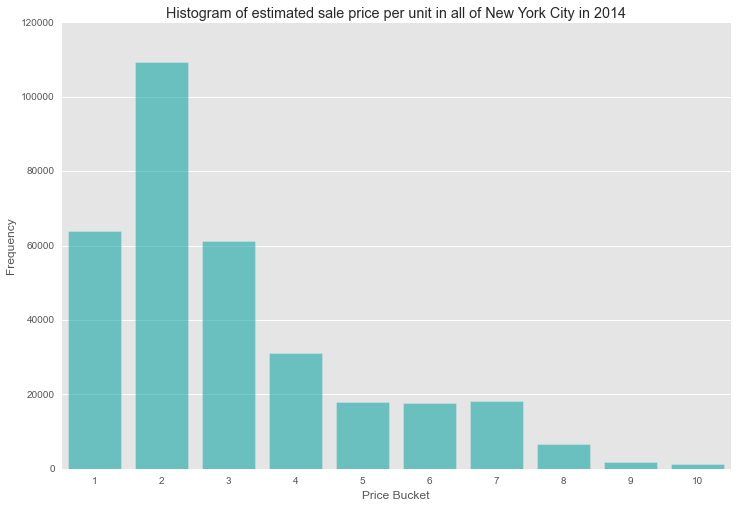

In [26]:
# Get counts of the different bins, faster than conventional histogram
count = {}
for i in final['PRICE_UNIT_BINS']:
    count[i] = count.get(i, 0) + 1  
    
fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame.from_dict(count, 'index')
sns.barplot(x=df.index,y=df[0],color='c',alpha=0.6)
plt.title('Histogram of estimated sale price per unit in all of New York City in 2014')
plt.ylabel('Frequency')
plt.xlabel('Price Bucket')
ax.xaxis.get_majorticklocs()
del df

In [27]:
final = final.merge(zipcodes,on='ZIP_CODE',how='inner')
final = gpd.GeoDataFrame(final) # For plotting

### Estimate price increase from 2009 to 2014 in percentage terms

In [28]:
# From Zillow
# http://www.zillow.com/new-york-ny/home-values/
(562-457)/457.0

0.22975929978118162

In [29]:
# From the data
((np.mean(final[final['SALE_YEAR']==2014]['SALE_PRICE_UNIT'])-
 np.mean(final[final['SALE_YEAR']==2009]['SALE_PRICE_UNIT']))/
 np.mean(final[final['SALE_YEAR']==2009]['SALE_PRICE_UNIT']))

0.3088979300819252

### Get Assessment data from DOF in order to compute effective tax rate (ETR)

In [30]:
assessment09 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_09.csv')
assessment10 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_10.csv')
assessment11 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_11.csv')
assessment12 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_12.csv')
assessment13 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_13.csv')
assessment14 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_14.csv')
assessment15 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_15.csv')

In [31]:
final.BBL = final.BBL.astype(str)

In [32]:
def prepare(x,y):
    del x['Unnamed: 0'] # Delete unnecessary columns
    x.rename(columns={'BBLE':'BBL'},inplace=True)
    # Make sure BBL is same type for merging
    x.BBL = x.BBL.astype(str)
    y = y.merge(x,on='BBL',how='inner')
    return y

In [33]:
# Break final back into the different sales years to merge with correct tax final
y2014 = final[final['SALE_YEAR']==2014]
y2013 = final[final['SALE_YEAR']==2013]
y2012 = final[final['SALE_YEAR']==2012]
y2011 = final[final['SALE_YEAR']==2011]
y2010 = final[final['SALE_YEAR']==2010]
y2009 = final[final['SALE_YEAR']==2009]
y2008 = final[final['SALE_YEAR']==2008]

In [34]:
# DOF data of a given year is for previous year
df2014 = prepare(assessment15,y2014)
df2013 = prepare(assessment14,y2013)
df2012 = prepare(assessment13,y2012)
df2011 = prepare(assessment12,y2011)
df2010 = prepare(assessment11,y2010)
df2009 = prepare(assessment10,y2009)
df2008 = prepare(assessment09,y2008)

In [35]:
headers = df2014.columns 
# Reunite data, use numpy because pandas is raising axis error
finale = pd.DataFrame(np.concatenate([df2008,df2009,df2010,df2011,df2012,df2013,df2014]))
finale.columns = headers
finale = finale.convert_objects(convert_dates=True,convert_numeric=True)

***MARKET VALUES***
- CUR_FV_T = AV-CUR-FULLVAL-TOTAL : If not zero, Current year’s total market value

***ASSESSED VALUES ( ACTUAL & TRANSITIONAL )*** : Contains the Assessed Values for the current fiscal year
- CUREXT = AV-CUREXT : Current Transitional Exempt Total Value
- CUREXT_A = AV-CUREXT-ACT : Current Actual Exempt Total Value
- CURAVT = AV-CURAVT : Current Transitional Assessed Total Value
- CURAVT_A = AV-CURAVT-ACT : Current Actual Assessed Total Value

***FINAL ASSESSED VALUES***
- FN_EXT = AV-FINAL-EXT : Final Transitional Exempt Total Value


### NOTES:
The law requires that the DOF uses whichever number is lower – the actual assessed value or transitional assessed value – to get to your property tax bill.
Your Assessed Value is based on a percentage of your Market Value. This percentage is known as the Level of Assessment or Assessment Ratio. Your Assessment Ratio depends on your tax class.

|Assessment Ratios|Percentage|
|:---------------:|:--------:|
|Tax class 1|	                6%|
|Tax class 2, 3 and 4 |   	45%|

***Transitional***

The DOF phases in changes to the assessed value of Class 2 properties with more than 10 units and Class 4 properties over a five-year period. This means that it applies 20% of the change each year for five years. 

#### Using DOF's Current Year Market Value as an approximation for market value. Using current actual exempt value.
One can do this using final values as well.

In [36]:
# Whole building
finale['TAXABLE_ACTUAL'] = finale['CURAVT_A'] - finale['CUREXT_A']
finale['TAX_PAID'] = finale.TAXABLE_ACTUAL * finale.TAX_RATE
finale['ETR_DOF'] = np.round((finale['TAX_PAID']/finale['CUR_FV_T'])*100,2) # Market value from DOF

#### Computing the ETR on an apartment level

In [37]:
# RESIDENTIAL UNITS is for some reason a multi-index column
l = np.array(finale['RESIDENTIAL_UNITS'].apply(lambda x: x))
l = l[:,0]
del finale['RESIDENTIAL_UNITS']
finale['RESIDENTIAL_UNITS'] = l

In [38]:
print ((len(finale['TOTAL_UNITS'])-list(finale['TOTAL_UNITS']==finale['TOT_UNIT']).count(True))/
        np.float(len(finale))*100)

37.1236869388


***38% of the total units info from the sales data does not match with the units info from assessment data.
Hence we pick assessment data from now on, since this is the information that is considered when paying taxes and thus assumed to be more likely to represent reality.***

In [39]:
# Calculating the number of units
# Total units in building
finale['TAX_UNIT'] = np.where(finale['TOT_UNIT']==0,1,finale['TOT_UNIT'])
# Number of units sold out of total, use sales data because it tells one how many apartments are included in the price
finale['SALE_UNIT'] = np.where(finale['RESIDENTIAL_UNITS']==0,1,finale['RESIDENTIAL_UNITS'])

In [40]:
# Estimate tax rate per unit
# Use AV-TOTAL-UNITS instead of TAX_UNITS, which is f(TOTAL_UNITS)
# because sales data is unreliable with regard to total units
# TAX_PAID is for the whole building, thus dividing by TAX_UNIT gives us a proxy for the taxes paid by each residential
# unit. To get the final effective tax rate, one divides by the sale price adjusted for whether an apartment was sold
# or the whole building.
finale['ETR_ACTUAL_UNIT'] = np.round((finale.TAX_PAID/finale['TAX_UNIT'])/
                                       (finale.SALE_PRICE/finale['SALE_UNIT']),4)*100

# Alternative to ETR_ACTUAL_UNIT
#finale['ETR_ACTUAL'] = np.where(((finale.SALE_PRICE/finale['SALE_UNIT'])*finale['TOT_UNIT'])==0,np.nan,
#                        np.round((finale.TAX_PAID/
#                    ((finale.SALE_PRICE/finale['SALE_UNIT'])*finale['TOT_UNIT'])),4)*100)

#### Looking at outliers

In [41]:
# Some data is inconsitent.
# For example here, 102 units are sold for $2,600,000 while the whole building has 105 units
# and paid $2,969,769 in taxes. Thus, the tax rate is higher than 100 Percent...
finale[finale['ETR_ACTUAL_UNIT']>100][['SALE_PRICE','TAX_UNIT','TOT_UNIT',
                                           'RES_UNIT','SALE_UNIT','TAX_PAID','ETR_ACTUAL_UNIT','BBL',
                                         'RESIDENTIAL_UNITS','CURAVT_A','CUREXT_A',
                                         'TOTAL_UNITS','APARTMENT_NUMBER']][:5]

,SALE_PRICE,TAX_UNIT,TOT_UNIT,RES_UNIT,SALE_UNIT,TAX_PAID,ETR_ACTUAL_UNIT,BBL,RESIDENTIAL_UNITS,CURAVT_A,CUREXT_A,TOTAL_UNITS,APARTMENT_NUMBER
842,385000,196,196,196,196,1130098.06,293.53,1007691104,196,8820000,126938,196,NaN
4502,850000,144,144,144,144,922371.19,108.51,1005601003,144,7245000,149837,144,3
4527,453000,229,229,229,229,1432268.50,316.17,1005611003,229,11205000,187550,229,NaN
4960,460000,62,62,62,62,527959.64,114.77,1008820052,62,4158000,96772,62,NaN
5236,395000,243,243,236,236,1927252.08,473.86,1008900001,236,14985000,159984,243,NaN


In [42]:
finale[finale['BBL']==4084890001][:5]

,ZIP_CODE,SALE_DATE,SALE_YEAR,PRICE_BINS,TAX_CLASS_AT_PRESENT,APARTMENT_NUMBER,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_PRICE_UNIT,BBL,...,FN_AVT,FN_EXT,TXCL,TAXABLE_ACTUAL,TAX_PAID,ETR_DOF,RESIDENTIAL_UNITS,TAX_UNIT,SALE_UNIT,ETR_ACTUAL_UNIT
35238,11005,2008-01-14,2008,3,2,NaN,2,500000,500000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,1.67
35239,11005,2008-01-09,2008,2,2,NaN,2,275000,275000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,3.03
35240,11005,2008-01-10,2008,3,2,NaN,2,445000,445000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,1.87
35241,11005,2008-02-14,2008,2,2,NaN,2,290000,290000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,2.88
35242,11005,2008-02-29,2008,3,2,NaN,2,536496,536496,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,1.55


In [43]:
# Some buildings are not paying taxes at all
finale[finale['ETR_DOF']==0][['TAX_PAID','CURAVT_A','TAX_RATE','CUREXT_A']].head()

,TAX_PAID,CURAVT_A,TAX_RATE,CUREXT_A
1330,0,7875000,0.13,7875000
1331,0,7875000,0.13,7875000
1332,0,7875000,0.13,7875000
1333,0,7875000,0.13,7875000
1381,0,1467000,0.13,1467000


#### Clean the data

In [44]:
print len(finale[(finale['ETR_ACTUAL_UNIT']>20)|(finale['ETR_DOF']==0)|(finale['ETR_ACTUAL_UNIT']>20)]) # observations are outliers...

2876


In [45]:
finale = finale[(finale['ETR_ACTUAL_UNIT']<20)&(finale['ETR_DOF']!=0)&(finale['ETR_ACTUAL_UNIT']<20)]

#### Compare Tax Rates

In [46]:
taxrates = pd.DataFrame({'ETR_ACTUAL_MEAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                            'ETR_ACTUAL_MEDIAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_ACTUAL_UNIT'].median(),
                            'ETR_DOF_MEAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_DOF'].mean(),
                        'ETR_DOF_MEDIAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_DOF'].median()}).reset_index()

In [47]:
taxrates

,PRICE_UNIT_BINS,ETR_ACTUAL_MEAN,ETR_ACTUAL_MEDIAN,ETR_DOF_MEAN,ETR_DOF_MEDIAN
0,1,1.433736,1.22,3.151049,3.90
1,2,0.914272,0.80,3.019811,1.93
2,3,0.813064,0.70,3.048099,1.64
3,4,0.786329,0.73,3.468048,5.40
4,5,0.765016,0.74,3.862423,5.66
5,6,0.698273,0.69,4.190849,5.70
6,7,0.594354,0.57,4.347431,5.74
7,8,0.459789,0.44,4.459669,5.78
8,9,0.337159,0.33,4.271320,5.78
9,10,0.238179,0.21,4.059275,5.78


CPU times: user 23.4 s, sys: 263 ms, total: 23.6 s
Wall time: 23.6 s


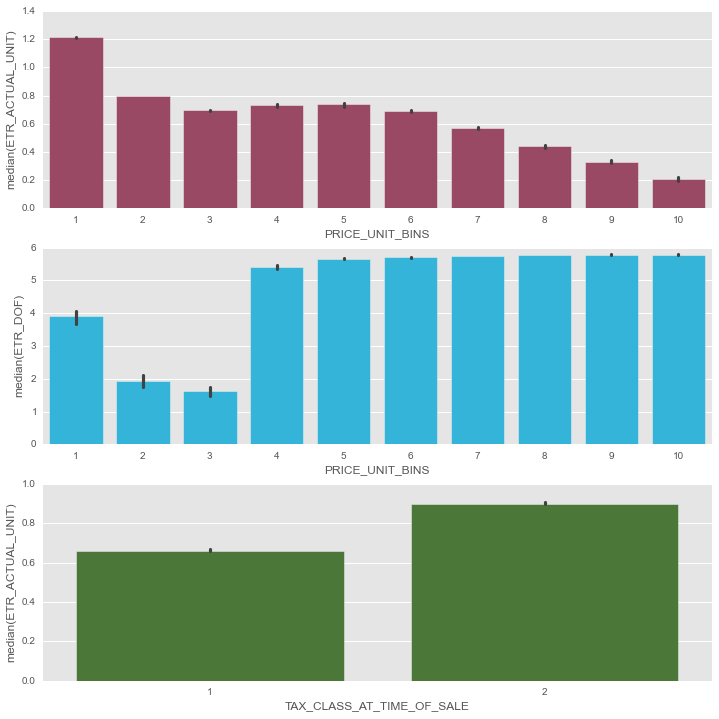

In [48]:
%%time
# Use all processors
pool = mp.Pool()
# Visualize it
from numpy import median, mean
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=False)
sns.barplot(x='PRICE_UNIT_BINS', y='ETR_ACTUAL_UNIT', data=finale, estimator=median, ax=ax1, color='#AA385E', saturation=0.7, 
            order=[1,2,3,4,5,6,7,8,9,10])
sns.barplot(x='PRICE_UNIT_BINS', y='ETR_DOF', data=finale, estimator=median, ax=ax2, color='#12C7FD', saturation=0.7,
           order=[1,2,3,4,5,6,7,8,9,10])
sns.barplot(x='TAX_CLASS_AT_TIME_OF_SALE', y='ETR_ACTUAL_UNIT', data=finale, estimator=median, ax=ax3, color='#45842B', 
            saturation=0.7)

*** The way DOF assesses market values is counter the actual market evaluation of property, especially for estate in price bins above 5. This essentially creates inequality as more expensive estates pay less tax.***

CPU times: user 358 ms, sys: 179 ms, total: 537 ms
Wall time: 538 ms


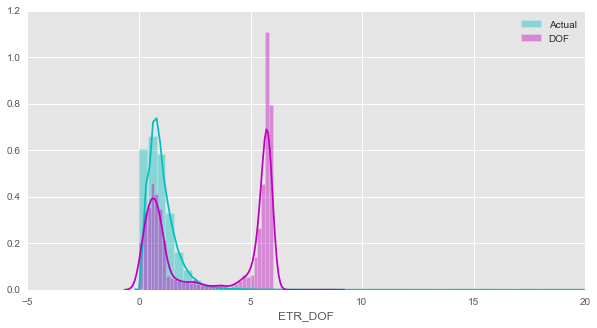

In [49]:
%%time
# Use all processors
pool = mp.Pool()
plt.figure(figsize=(10,5))
sns.distplot(finale.ETR_ACTUAL_UNIT.dropna(),color='c',label='Actual')
sns.distplot(finale.ETR_DOF.dropna(),color='m',label='DOF')
plt.legend()

In [50]:
# Create new index, since old is not coherent anymore after cleaning data
finale = finale.reset_index()
del finale['index']

CPU times: user 4.32 s, sys: 780 ms, total: 5.1 s
Wall time: 4.68 s


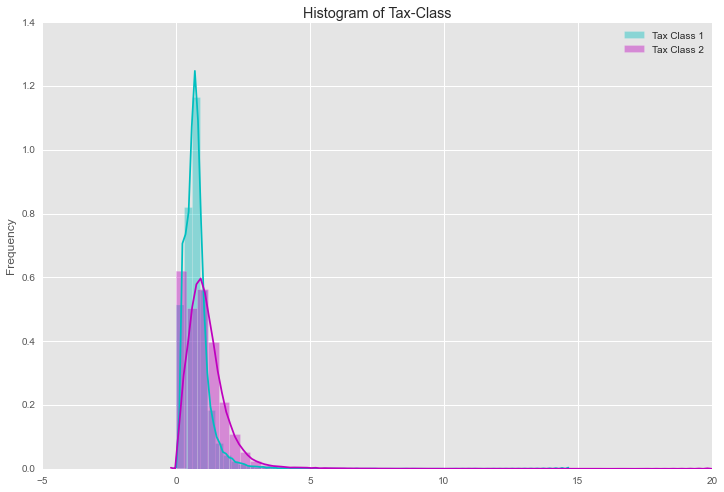

In [51]:
%%time
# Use all processors
pool = mp.Pool()
# Get counts of the different bins, faster than conventional histogram
ETR_1 = []
ETR_2 = []
for i,l in enumerate(finale['TAX_CLASS_AT_PRESENT']):
    if str(l).find('1')!=-1:
        ETR_1.append(finale['ETR_ACTUAL_UNIT'][i])
    elif str(l).find('2')!=1:    
        ETR_2.append(finale['ETR_ACTUAL_UNIT'][i])
ETR_1 = pd.Series(ETR_1)
ETR_2 = pd.Series(ETR_2)
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(ETR_1.dropna(),color='c', label='Tax Class 1')
sns.distplot(ETR_2.dropna(),color='m',label='Tax Class 2')
plt.title('Histogram of Tax-Class')
plt.ylabel('Frequency')
plt.legend()
ax.xaxis.get_majorticklocs();

#### Data appears to be normally distributed, although heavily skewed.

##### Hypothesis
The research question's aim is to see whether residents of tax class 2 property pay more in ETR than residents of tax class 1 property.

$H_0: \mu_1=\mu_2$

$H_1: \mu_1\neq\mu_2 $

At $\alpha=0.05$

Now we analyze the dataset in terms of standard deviation and other important moments in order to compute the t-statistic. We consider the 2014 sample to be a sample for all estates in New York City. We compare two means, thus we apply the formula for the Welch's t-test:
<br>
<br>
<br>
$t=\frac{\mu_1-\mu_2}{\sqrt{\frac{s_{1}^2}{n_1}+\frac{s_{2}^2}{n_2}}}$
<br>
<br>
<br>
We make use of the Central Limit Theorem and assume that due to the large sample size, the data can be approximated by a normal distribution, eventhough the normal test shows that the sample does not behave normally distributed even after cleaning and adjusting for the skewness.

In [52]:
# Clean data
def clean(x):
    x = pd.Series(x)
    x = x[x>0].dropna()
    return x

ETR_1 = clean(ETR_1)
ETR_2 = clean(ETR_2)


import scipy
print scipy.stats.mstats.normaltest(ETR_1.apply(lambda x: np.log(x)))
print scipy.stats.mstats.normaltest(ETR_2.apply(lambda x: np.log(x)))

# Getting standard deviation for each usertype and other moments:
def parameters(x):
    mean = x.mean()
    std = x.std()
    count = x.count()
    return mean,std,count

m1,s1,n1 = parameters(ETR_1)
m2,s2,n2 = parameters(ETR_2)

# Compute the t-stat:
t = (m1 - m2)/math.sqrt((s1**2/n1)+(s2**2/n2))
print t

print n1,n2

(16084.737997419503, 0.0)
(51202.383659987187, 0.0)
-119.027921409
70227 163206


The degrees of freedom (df) is bigger is defined as n-1. For both samples, df is > 120. For an $\alpha$ of 5%, the critical t-value for df$\approx\inf$ is 1.960. Thus, our t-value exceeds the critical value. 

***Conclusion***

Based on the critical value and p-value we reject $H_0$ and can say that Tax class 1 residents pay on average a different amount than tax class 2 residents.

#### Relationship between Market Value and Sales Price

In [53]:
# Market is taken from DOF calculations and sale price from actual sales adjusted for the units
finale['MKT_SALE'] = np.round((finale.CUR_FV_T/finale.TAX_UNIT/finale.SALE_PRICE_UNIT)*100,2)

# Difference between market value and sales price in percentage terms
finale['MKT_SALE_PERC'] = np.where((finale.SALE_PRICE_UNIT*finale.TOTAL_UNITS)==0,np.nan,
    np.round(finale.CUR_FV_T/(finale.SALE_PRICE_UNIT*finale.TOTAL_UNITS)*100,2))

# Percentage of exemptions
finale['EXT_PERC'] = np.round(finale.CUREXT_A/finale.CURAVT_A*100,2)

finale[['ETR_ACTUAL_UNIT','MKT_SALE','MKT_SALE_PERC','EXT_PERC','ETR_DOF']].describe()

,ETR_ACTUAL_UNIT,MKT_SALE,MKT_SALE_PERC,EXT_PERC,ETR_DOF
count,252729.000000,252729.000000,160984.000000,233996.000000,233996.000000
mean,0.924517,52.611372,66.709572,13.885724,3.344367
std,0.886100,84.318098,73.958332,25.796150,2.415667
min,0.000000,0.000000,0.000000,0.000000,0.010000
25%,0.420000,15.500000,16.040000,0.000000,0.740000
50%,0.790000,26.500000,45.230000,2.930000,4.710000
75%,1.230000,83.230000,100.970000,9.660000,5.720000
max,19.790000,13848.630000,5500.550000,99.900000,8.550000


#### Using sales price as an approximation for market value. Using current actual exempt value.
Need to check whether sales price includes the whole building or just the apartment, since assessment data is on the whole building.

## Timeanalysis

In [54]:
time = pd.DataFrame({'ETR_ACTUAL_UNIT_MEAN':finale.groupby('SALE_YEAR',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                            'ETR_ACTUAL_UNIT_MEDIAN':finale.groupby('SALE_YEAR',axis=0)['ETR_ACTUAL_UNIT'].median(),
                            'ETR_ACTUAL_UNIT_STD':finale.groupby('SALE_YEAR',axis=0)['ETR_ACTUAL_UNIT'].std()}).reset_index()

In [55]:
time

,SALE_YEAR,ETR_ACTUAL_UNIT_MEAN,ETR_ACTUAL_UNIT_MEDIAN,ETR_ACTUAL_UNIT_STD
0,2008,0.797765,0.66,0.832195
1,2009,0.904240,0.78,0.911284
2,2010,0.860064,0.73,0.870538
3,2011,0.928674,0.81,0.883748
4,2012,1.022318,0.87,1.021216
5,2013,0.994444,0.87,0.863228
6,2014,0.937435,0.81,0.800778


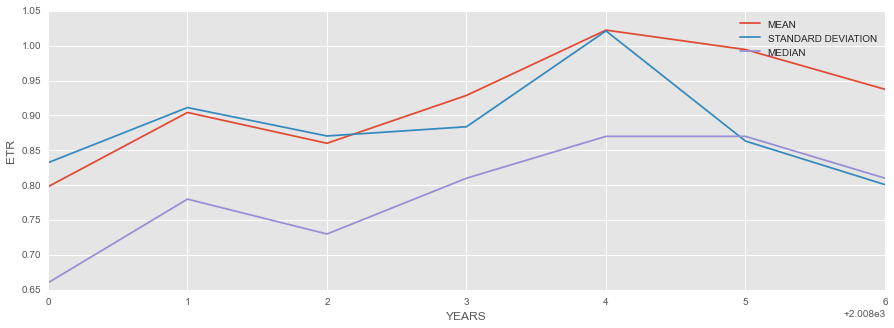

In [56]:
# Plot the response with standard error
#sns.tsplot(data=time, time="SALE_YEAR", unit="ETR_ACTUAL_UNIT_MEAN",
#          value="ETR_ACTUAL_UNIT_STD")
plt.figure(figsize=(15,5))
plt.plot(time.SALE_YEAR,time.ETR_ACTUAL_UNIT_MEAN,label='MEAN')
plt.plot(time.SALE_YEAR,time.ETR_ACTUAL_UNIT_STD,label='STANDARD DEVIATION')
plt.plot(time.SALE_YEAR,time.ETR_ACTUAL_UNIT_MEDIAN,label='MEDIAN')
plt.ylabel('ETR')
plt.xlabel('YEARS')
plt.legend()

The average ETR across the city increased over the years, while the standard deviation decreased. The median ETR did not increase as heavily.

In [59]:
buildings = pd.DataFrame(
    {'STD_UNIT':finale.groupby('BUILDING_CLASS_AT_TIME_OF_SALE',axis=0)['ETR_ACTUAL_UNIT'].std(),
    'MEAN_UNIT':finale.groupby('BUILDING_CLASS_AT_TIME_OF_SALE',axis=0)['ETR_ACTUAL_UNIT'].mean(),
    'MEDIAN_UNIT':finale.groupby('BUILDING_CLASS_AT_TIME_OF_SALE',axis=0)['ETR_ACTUAL_UNIT'].median()}).reset_index()

In [61]:
buildings[:10]

,BUILDING_CLASS_AT_TIME_OF_SALE,MEAN_UNIT,MEDIAN_UNIT,STD_UNIT
0,A0,0.788567,0.75,0.429046
1,A1,0.771419,0.72,0.455452
2,A2,0.816765,0.78,0.436383
3,A3,0.805196,0.76,0.574744
4,A4,0.565963,0.46,0.520986
5,A5,0.742152,0.73,0.419364
6,A6,0.674802,0.61,0.370218
7,A7,0.722250,0.51,0.723111
8,A9,0.690243,0.65,0.452695
9,B1,0.753081,0.67,0.590836


## ETR data per zipcode for visualization

In [62]:
ETR_UNIT_ZIP = pd.DataFrame({'STD_UNIT':finale.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].std(),
                            'MEAN_UNIT':finale.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                            'MEDIAN_UNIT':finale.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].median()}).reset_index()

In [63]:
def plot(df,color,title,column):
    df = df.merge(zipcodes, on='ZIP_CODE',how='inner')
    df_ = gpd.GeoDataFrame(df)
    f, ax = plt.subplots(figsize=(12,8));
    ax.set_axis_bgcolor(color);
    plt.grid('off');
    df_.plot(column=column, scheme='QUANTILES', k=7, alpha=0.6, colormap='YlOrRd', axes=ax, legend=True);
    title = title + ' : ' + column.lower()
    plt.title(title);

In [ ]:
plot(ETR_UNIT_ZIP,'#C9C1C1','ETR per taxable unit','MEDIAN_UNIT')

In [ ]:
ETR_BUILDING_ZIP = pd.DataFrame({'STD_BUILDING':finale.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].std(),
                            'MEAN_BUILDING':finale.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].mean(),
                'MEDIAN_BUILDING':finale.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].median()}).reset_index()

In [ ]:
ETR_BUILDING_ZIP[:4]

In [ ]:
plot(ETR_BUILDING_ZIP,'#C9C1C1','ETR per building','MEDIAN_BUILDING')

### As a share of income

In [ ]:
# Read income data and merge data
income = pd.read_csv(zip_.open(filename_income))
income.drop(0,inplace=True)
income.rename(columns={'GEO.id2':'ZIP_CODE','HC02_EST_VC02':'MEDIAN_INCOME'},inplace=True)
income = income[['ZIP_CODE','MEDIAN_INCOME']]
income['ZIP_CODE'] = income['ZIP_CODE'].astype(int)
income['MEDIAN_INCOME'] = income['MEDIAN_INCOME'].apply(lambda x: x.replace(',','').strip('+').strip())
income['MEDIAN_INCOME'] = np.where(income['MEDIAN_INCOME']=='-',np.nan,income['MEDIAN_INCOME'])
income['MEDIAN_INCOME'] = np.round(income['MEDIAN_INCOME'].astype(float),1)
data_with_income = income.merge(finale,how='inner',on='ZIP_CODE')

In [ ]:
#data_with_income['ETR_UNIT_SHARE_OF_INCOME'] = (((data_with_income['TAX_RATE_PER_UNIT']/100)*
#                    data_with_income['MEDIAN_INCOME'])/data_with_income['MEDIAN_INCOME'])*100

In [ ]:
#ETR_SHARE_INCOME_ZIP = pd.DataFrame({'STD_SHARE_INCOME':data_with_income.groupby('ZIP_CODE',
#                                                                    axis=0)['ETR_UNIT_SHARE_OF_INCOME'].std(),
#'MEAN_SHARE_INCOME':data_with_income.groupby('ZIP_CODE',axis=0)['ETR_UNIT_SHARE_OF_INCOME'].mean(),
#'MEDIAN_SHARE_INCOME':data_with_income.groupby('ZIP_CODE',axis=0)['ETR_UNIT_SHARE_OF_INCOME'].median()}).reset_index()
#plot(ETR_SHARE_INCOME_ZIP,'#C9C1C1','ETR as Share of Median Income','MEDIAN_SHARE_INCOME')

### Summaries by Zip Codes

In [ ]:
# Get statistics
print final['SALE_PRICE'].groupby(final['TAX_CLASS_AT_TIME_OF_SALE']).mean()
print final['SALE_PRICE'].groupby(final['TAX_CLASS_AT_TIME_OF_SALE']).std()

# Get summaries
tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                     'PRICE_BINS'],axis=0).size()}).reset_index()
total_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                       'PRICE_BINS','ZIP_CODE'],axis=0).size()}).reset_index()
total1 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==1]['COUNT'].sum()
total2 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2]['COUNT'].sum()
tax_breakdown['SHARE'] = np.where(tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2,
                                  tax_breakdown['COUNT']/total2, tax_breakdown['COUNT']/total1)
del total1
del total2
zip_price_breakdown = pd.DataFrame({'COUNT':final.groupby(['ZIP_CODE',
                                                         'PRICE_UNIT_BINS'],axis=0).size()}).reset_index()

zip_tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['ZIP_CODE',
                                                         'TAX_CLASS_AT_TIME_OF_SALE'],axis=0).size()}).reset_index()
total_per_zip = pd.DataFrame({'TOTAL_COUNT':final.groupby(['ZIP_CODE'],axis=0).size()}).reset_index()

# Normalize each count by total sales count and maybe by population
zip_tax_breakdown = zip_tax_breakdown.merge(total_per_zip,on='ZIP_CODE',how='inner')
del total_per_zip

In [ ]:
# Add share of tax class two per zip code, merge it with tax data for tableu.
zip_tax_breakdown['SHARE_CLASS_2'] = zip_tax_breakdown.COUNT/zip_tax_breakdown.TOTAL_COUNT
tax_info = zip_tax_breakdown[zip_tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2]
tax_info.drop(['TAX_CLASS_AT_TIME_OF_SALE','COUNT'],axis=1,inplace=True)

#### Get price bin info per zip code, without tax class at time of sale

In [ ]:
zip_price_breakdown = tax_info.merge(zip_price_breakdown,on='ZIP_CODE',how='inner')
zip_price_breakdown['SHARE_PRICE_UNIT_BINS'] = zip_price_breakdown.COUNT/zip_price_breakdown.TOTAL_COUNT
zip_price_breakdown.drop('COUNT',axis=1,inplace=True)
zip_info = pd.DataFrame(index=np.unique(zip_price_breakdown.ZIP_CODE.values))

In [ ]:
# Create new dataframe that stores the most prevalent price bin present in each zip code
zip_info['PREVALENT_PRICE_UNIT_BINS_SHARE'] = np.zeros
zip_info['PREVALENT_PRICE_UNIT_BINS'] = np.zeros
for i in zip_info.index.values:
    value = zip_price_breakdown.ix[
        zip_price_breakdown[zip_price_breakdown['ZIP_CODE']==i]
        ['SHARE_PRICE_UNIT_BINS'].idxmax()]['SHARE_PRICE_UNIT_BINS']
    bin_info = zip_price_breakdown.ix[
        zip_price_breakdown[zip_price_breakdown['ZIP_CODE']==i]
        ['SHARE_PRICE_UNIT_BINS'].idxmax()]['PRICE_UNIT_BINS']
    zip_info['PREVALENT_PRICE_UNIT_BINS_SHARE'].iloc[zip_info.index==i] = value
    zip_info['PREVALENT_PRICE_UNIT_BINS'].iloc[zip_info.index==i] = bin_info
    
zip_info = zip_info.reset_index()
zip_info.rename(columns={'index':'ZIP_CODE'},inplace=True)
# Add info by merging
zip_info = zip_info.merge(tax_info,on='ZIP_CODE',how='inner')
zip_info = zip_info.merge(ETR_BUILDING_ZIP,on='ZIP_CODE',how='inner')
zip_info = zip_info.merge(ETR_SHARE_INCOME_ZIP,on='ZIP_CODE',how='inner')
zip_info = zip_info.merge(ETR_UNIT_ZIP,on='ZIP_CODE',how='inner')

In [ ]:
# Add geometry for visualization
zip_info = zip_info.merge(zipcodes,on='ZIP_CODE',how='inner')

In [ ]:
zip_info.columns

In [ ]:
# Add quantiles for better visualization
zip_info['MEDIAN_SHARE_INCOME_Q'] = pd.qcut(zip_info['MEDIAN_SHARE_INCOME'],5,labels=np.arange(1,6))
zip_info['MEDIAN_BUILDING_Q'] = pd.qcut(zip_info['MEDIAN_BUILDING'],5,labels=np.arange(1,6))
zip_info['MEDIAN_UNIT_Q'] = pd.qcut(zip_info['MEDIAN_UNIT'],5,labels=np.arange(1,6))

In [ ]:
zip_info.to_csv('zip_info.csv') # For visualization in Tableau

#### Investigate ETR differences among classes

In [ ]:
tax = pd.DataFrame({'MEDIAN':data_with_income['TAX_RATE_PER_UNIT'].groupby(
                                                    data_with_income['TAX_CLASS_AT_TIME_OF_SALE'],axis=0).median()}).reset_index()

In [ ]:
tax # Do anova to see whether means are significantly different

## Tableau
https://public.tableau.com/shared/H85S34NQC?:display_count=yes

#### TAX 1 and TAX 2

In [ ]:
tax1 = finale[finale['TAX_CLASS_AT_TIME_OF_SALE']==1]

In [ ]:
# Tax class 1
tax_class_1 = pd.DataFrame({'STD_BUILDING':tax1.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].std(),
                            'MEAN_BUILDING':tax1.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].mean(),
                'MEDIAN_BUILDING':tax1.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].median()}).reset_index()
plot(tax_class_1,'#C9C1C1','ETR for tax class 1','MEDIAN_BUILDING')

In [ ]:
tax2 = finale[finale['TAX_CLASS_AT_TIME_OF_SALE']==2]

In [ ]:
# Tax class 2
tax_class_1 = pd.DataFrame({'STD_BUILDING':tax2.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].std(),
                            'MEAN_BUILDING':tax2.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].mean(),
                'MEDIAN_BUILDING':tax2.groupby('ZIP_CODE',axis=0)['EST_TAX_RATE_ACTUAL'].median()}).reset_index()
plot(tax_class_1,'#C9C1C1','ETR for tax class 2','MEDIAN_BUILDING')

In [ ]:
# Alternate measure of ETR per Median Income
#data_with_income['ETR_UNIT_INCOME'] = ((data_with_income['TAX_RATE_PER_UNIT']*10000000)
#                    /data_with_income['MEDIAN_INCOME'])

In [ ]:
finale.columns

In [ ]:
test = pd.DataFrame({'STD_BUILDING':finale.groupby('PRICE_UNIT_BINS',axis=0)['EST_TAX_RATE_ACTUAL'].std(),
                'MEAN_BUILDING':finale.groupby('PRICE_UNIT_BINS',axis=0)['EST_TAX_RATE_ACTUAL'].mean(),
        'MEDIAN_BUILDING':finale.groupby('PRICE_UNIT_BINS',axis=0)['EST_TAX_RATE_ACTUAL'].median()}).reset_index()

In [ ]:
finale['UNIT_BINS_TEST'] = pd.qcut(finale['SALE_PRICE_UNIT'],10,labels=np.arange(1,11))

In [ ]:
test = pd.DataFrame({'STD_BUILDING':finale.groupby('UNIT_BINS_TEST',axis=0)['EST_TAX_RATE_ACTUAL'].std(),
                'MEAN_BUILDING':finale.groupby('UNIT_BINS_TEST',axis=0)['EST_TAX_RATE_ACTUAL'].mean(),
        'MEDIAN_BUILDING':finale.groupby('UNIT_BINS_TEST',axis=0)['EST_TAX_RATE_ACTUAL'].median()}).reset_index()